In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

sys.path.append('../')
from utils import imshow

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Intensity Transformation and Spatial Filtering

The **spatial domain** is the (height-width) plane containing the pixels of an image. The transformations on spatial
domain usually involve transforming the intensity of a pixel according to the intensity of its neighbours. When the
shape of the neighbourhood is fixed, we move the neighbourhood template (also called mask, kernel, window, or filter)
across the spatial domain, and perform a transformation at each stop. This kind of procedure is called *spatial 
filtering*.

In the simplest case, the neighbourhood consists of only the pixel to be transformed, and the transformation can be
represented as:

$$ s = T(r) $$

where $r, s$ are the intensities of the same pixel before and after the transformation respectively. We call this
kind of procedure *intensity transformation*. For discrete intensities, intensity transformation can be implemented via table lookups.

## Intensity Transformations

### Image Negatives

The negative of an image with intensity levels in range $[0, L - 1]$ is given by:

$$ s = L - 1 - r $$

Useful for enhancing white or gray detail embedded in dark regions of an image, especially when the black areas are
dominant in size.

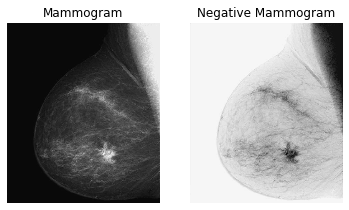

In [2]:
mammogram = cv.imread('../resource/Fig0304(a)(breast_digital_Xray).tif', 
                      cv.IMREAD_GRAYSCALE)

# Grayscale image has 2**8 grayscales.
negative_mammogram = 2 ** 8 - 1 - mammogram

# Plot these two images side by side.
imshow(mammogram, 121, title='Mammogram')
imshow(negative_mammogram, 122, title='Negative Mammogram')

plt.show()

### Log Transformations

The general form of log transformation is:

$$ s = c\log(1 + r) $$

where $r \ge 0$

**Characteristic:**
* map a narrow range of low intensity values into a wider range.
* map a wide range of high intensity values into a narrower range.

Useful for expanding the values of dark pixels while compressing the higher-level values.

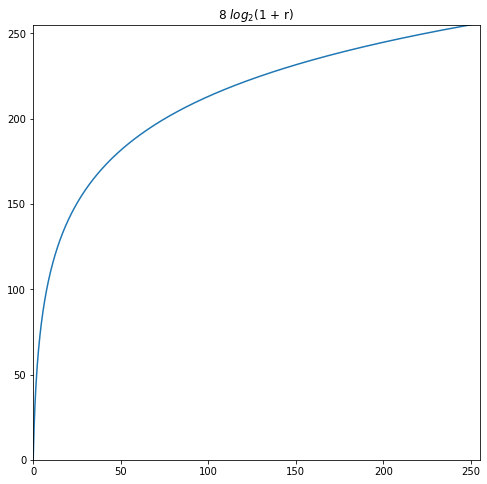

In [3]:
r = np.linspace(0, 255, 1000)
c = 256 / 8

plt.figure(figsize=(8, 8))
plt.axis([0, 255, 0, 255])
plt.plot(r, c * np.log2(1 + r))
plt.title('8 $log_2$(1 + r)')
plt.show()

### Gamma Transformations

The general form of gamma (power-law) transformation (also called *gamma correction*) is:

$$ s = c\, r^\gamma $$

where $c, \gamma$ are positive constants.

**Note:** 
* In order to keep the intensity range invariant, we can scale the grayscale value into interval `[0, 1]` (e.g. divide by 255) before the gamma transformation and then scale it back (e.g. multiply by 255) after the transformation.

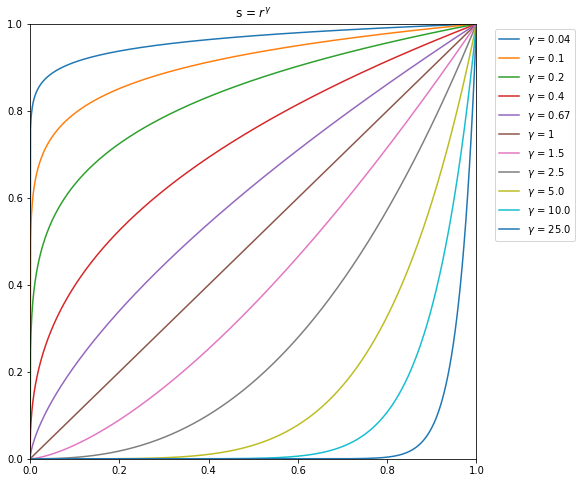

In [4]:
xs = np.linspace(0, 1, 1000)

gammas = (0.04, 0.10, 0.20, 0.40, 0.67, 1, 1.5, 2.5, 5.0, 10.0, 25.0)

plt.figure(figsize=(8, 8))
plt.axis([0, 1, 0, 1])
plt.title('s = $r^\gamma$')
for gamma in gammas:
    plt.plot(xs, np.power(xs, gamma), label=f'$\gamma$ = {gamma}')
plt.legend(bbox_to_anchor=(1.03, 1))
plt.show()

From the above figure, we can see that when $\gamma < 1.0$ the gamma transformation:

* maps a narrow range of low intensity values into a wider range.
* maps a wide range of high intensity values into a narrower range.

This is just like the log transformation. But when $\gamma > 1.0$ the gamma transformation has the
opposite effects.

In [5]:
def gamma_correct(image, gamma=1.0):
    """Perform the gamma correction on image.

    Note: currently, it only supports transformations for grayscale
    images.

    Parameters
    ----------
    image: 2-dim ndarray
        The input grayscale image.
    gamma: nonnegative float
        Gamma value.
    Returns
    -------
    2-dim ndarray
        Gamma corrected image with the same shape as input image.
    """
    # Sanity checks.
    if gamma < 0.0:
        raise ValueError('Gamma value should be non-negative')
    if gamma == 1.0:
        return image
    
    # Gamma transformation lookup talbe.
    L = 256
    lookup_table = np.arange(L, dtype=np.float)
    np.power(lookup_table / (L - 1), gamma, out=lookup_table)
    np.rint(lookup_table * (L - 1), out=lookup_table)
    lookup_table = lookup_table.astype(np.uint8)

    return lookup_table[image]

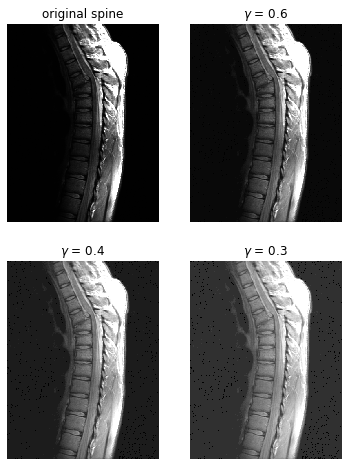

In [6]:
spine = cv.imread('../resource/Fig0308(a)(fractured_spine).tif',
                  cv.IMREAD_GRAYSCALE)

gammas = [1.0, 0.6, 0.4, 0.3]
i = 1
plt.figure(figsize=(6, 8))
for gamma in gammas:
    if i == 1:
        imshow(spine, 221, title='original spine')
    else:
        corrected_image = gamma_correct(spine, gamma=gamma)
        imshow(corrected_image, position=(2, 2, i), title=f'$\gamma$ = {gamma}')
    i += 1
plt.show()

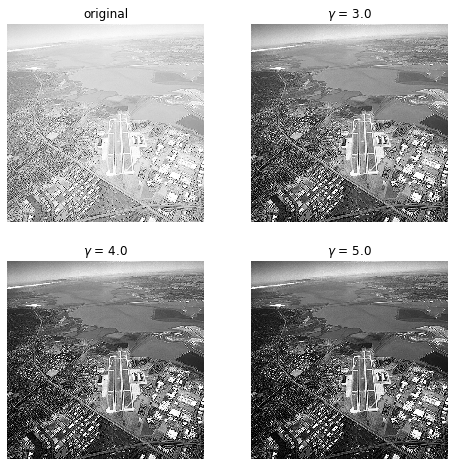

In [7]:
aerial_image = cv.imread('../resource/Fig0309(a)(washed_out_aerial_image).tif',
                         cv.IMREAD_GRAYSCALE)

gammas = [1.0, 3.0, 4.0, 5.0]
i = 1
plt.figure(figsize=(8, 8))
for gamma in gammas:
    if i == 1:
        imshow(aerial_image, 221, title='original')
    else:
        corrected_image = gamma_correct(aerial_image, gamma=gamma)
        imshow(corrected_image, position=(2, 2, i), title=f'$\gamma$ = {gamma}')
    i += 1
plt.show()

### Piecewise-linear Transformations

* **Pros:** more flexible than the above intensity transformations;
* **Cons:** more complex to implement.

#### Contrast stretching

#### Intensity-level slicing

*Intensity-level slicing* is the process of **highlighting a specific range of intensities in an image which is of interest**.

Two basic forms:

1. Dichotomization: display all values in the range of interest as one value (e.g. white) and the rest another (e.g. black).

2. Brighten (darken) the desired range of intensities and leave the rest unchanged.

#### Bit-plane slicing

*Bit-plane slicing* is the process of **slicing the intensities according to a specific bit** rather than a specific range.

Useful for:

* analyzing the relative importance of each bit in the image;

* image compression.

In [8]:
def bit_planes(image):
    """Return the bit planes of an image.
    
    Parameters
    ----------
    image : np.ndarray
        The input grayscale image.
    
    Returns
    -------
    np.ndarray
        8 bit planes. The first dimension indicates the order of bits
        with zero corresponding to the least significant bit.
    """
    bit_mask = 1
    planes = np.empty((8, *image.shape), dtype=np.uint8)
    
    for i in range(8):
        cv.bitwise_and(image, bit_mask, planes[i])
        planes[i] //= bit_mask
        bit_mask <<= 1
    
    return planes

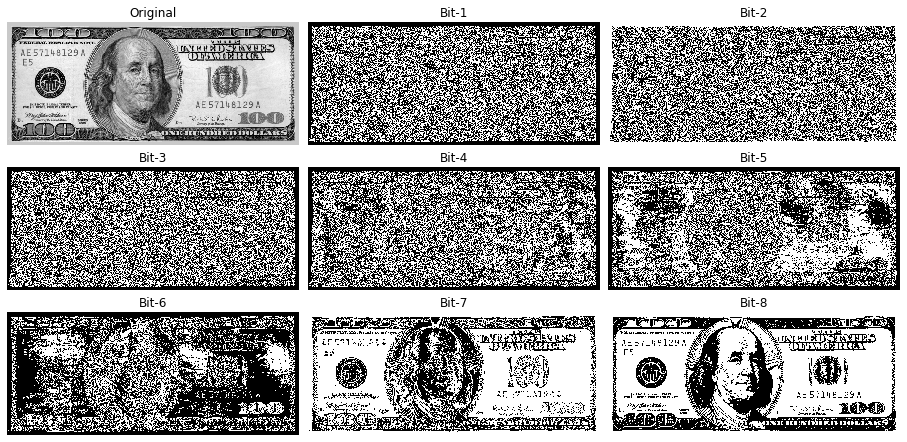

In [9]:
# Draw the bit planes along with the original image.
dollar = cv.imread('../resource/Fig0314(a)(100-dollars).tif',
                   cv.IMREAD_GRAYSCALE)

planes = bit_planes(dollar)

plt.figure(figsize=(16, 8))
imshow(dollar, 331, title='Original')
for i in range(8):
    imshow(planes[i], (3, 3, i+2), title=f'Bit-{i+1}')
plt.subplots_adjust(wspace=0.03, hspace=0)
plt.show()

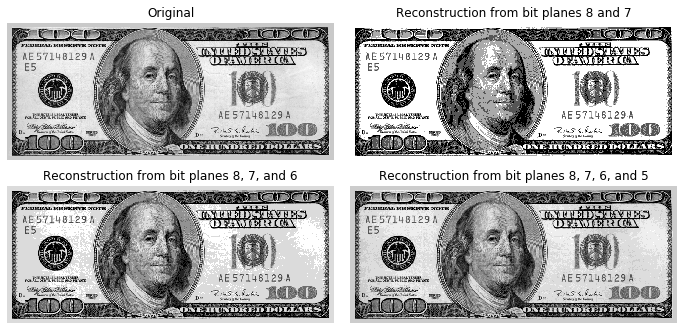

In [10]:
# Reconstruction from the bit planes.

reconstruction_87 = planes[7] * (2 ** 7) + planes[6] * (2 ** 6)
reconstruction_876 = reconstruction_87 + planes[5] * (2 ** 5)
reconstruction_8765 = reconstruction_876 + planes[4] * (2 ** 4)

plt.figure(figsize=(12, 6))
imshow(dollar, 221, title='Original')
imshow(reconstruction_87, 222,
       title='Reconstruction from bit planes 8 and 7')
imshow(reconstruction_876, 223,
       title='Reconstruction from bit planes 8, 7, and 6')
imshow(reconstruction_8765, 224,
       title='Reconstruction from bit planes 8, 7, 6, and 5')
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

## Histogram Processing


**Claim:** Let $R$ be a random variable with pdf $p_r(r)$. Let $F_r$ be the distribution of $R$, that is,
$$ F_r(r) = \mathop{P}(R \leq r) = \int_{-\infty}^r p_r(t) dt $$
Let $s = T(r)$ be a transformation of random variable and $F_s$ be the distribution of $S$. For simplicity, we assume that $T$ is strictly monotonic. Then we have:
$$ F_r(r) = F_s(s) $$
where $s = T(r)$.

### Histogram Equalization

*Histogram equalization* is the process of **generating an image with a flat (equalized) histogram from the given 
image**.

Consider for now that the pixel values are continuous in the range $[0, L - 1]$. Assume that $p_r(r)$ is the 
normalized histogram of the original image. We want to find a transformation $s = T(r)$ s.t. the histogram of the resulting image is flat, i.e. $p_s(s)$ is constant. For simplicity, we assume that $T$ is strictly increasing.

Since $p_s(s)$ is a normalized histogram, by definition we have:

$$ \int_0^{L - 1} p_s(s) ds = 1 $$

This implies that $p_s(s) = \frac{1}{L - 1}$ for all $s$. By the above claim about distribution function, we have:

$$ \int_0^r p_r(t)dt = \int_0^s p_s(t)dt = \int_0^s \frac{1}{L - 1}dt = \frac{s}{L - 1} $$

Hence we have:

$$\begin{equation}
s = (L - 1) \int_0^r p_r(t) dt
\end{equation}$$

And $s$ is indeed strictly increasing in $r$ if $p_r(r) > 0$ for all $r$. This is just the **cumulative  distribution function** of $r$.

For the discrete case, we just discretize the above transformation. The probability of occurrence of intensity value $k$ in an image with height $H$ and width $W$ is approximated by

$$\begin{equation}
p_r(k) = \frac{n_k}{HW} \quad k = 0, 1, \ldots, L - 1
\end{equation}$$

where $n_k$ is the number of pixels that have intensity value $k$. And $s_k = T(k)$ is given by

$$\begin{equation}
s_k = \frac{L - 1}{HW} \sum_{j = 0}^k n_j
\end{equation}$$

In [11]:
def equalize_histogram(image):
    """Generate an new image with a flat histogram from the given image.

    Note: currently, it only supports transformations for grayscale
    images.

    # TODO: Add support for normalization.

    Paramters
    ---------
    image: 2-dim ndarray of dtype uint8
        The input grayscale image.
    Returns
    -------
    2-dim ndarray of dtype uint8
        The histogram equalization of input image with the same shape
        and dtype.
    """
    L = 256  # number of intensity levels
    coefficient = (L - 1) / np.prod(image.shape)

    hist = np.histogram(image, bins=range(L + 1))[0]
    hist_cumsum = coefficient * np.cumsum(hist)
    equalization_map = np.rint(hist_cumsum).astype(np.uint8)

    return equalization_map[image]

### Histogram Matching (Specification)

*Histogram matching* is the process of **generating an image with a specified histogram from the given image**.

Similar to histogram equalization, we first consider continuous pixel values. Assume $p_s(s)$ is the given 
(normalized) histogram. We want to find a transformation $s = T(r)$ s.t. the histogram of the resulting image is
$p_s(s)$.

For simplicity, we assume that $s = T(r)$ is strictly monotonic. By the above claim we have

$$ F_s(s) = F_r(r) $$ 

where $s = T(r)$. If $F_s$ is invertible (e.g. when $p_s(s)$ is strictly positive), then we have

$$\begin{equation}
s = F_s^{-1}(F_r(r))
\end{equation}$$

Note that we can compute $F_s(s)$ from $p_s(s)$, hence the above equation yields the desired transformation.

In [ ]:
def match_histogram(image, target):
    """Generate an new image with the specified histogram from the given image.
    
    Parameters
    ----------
    image : np.ndarray
        The input grayscale image.
    target : np.ndarray
        The specified histogram of shape (256,).
    """
    L = 256
    image_hist = np.histogram(image, bins=range(L + 1))[0]
    image_cumhist = np.expand_dims(np.cumsum(image_hist), axis=1)  # (256, 1)
    target_cumhist = np.expand_dims(np.cumsum(target), axis=0)  # (1, 256)
    
    abs_diff = np.abs(image_cumhist - target_cumhist)  # (256, 256)
    matching_map = np.argmin(abs_diff, axis=1)  # (256,)
    
    return matching_map[image]

### Local Histogram Processing

## Spatial Filtering

### Fundamentals

### Smoothing Spatial Filters

### Sharpening Spatial Filters

## Fuzzy Techniques